# Problem Set 3
By: Bethany Bailey
MACS 30100

## Question 1
### (a)

<IPython.core.display.Javascript object>


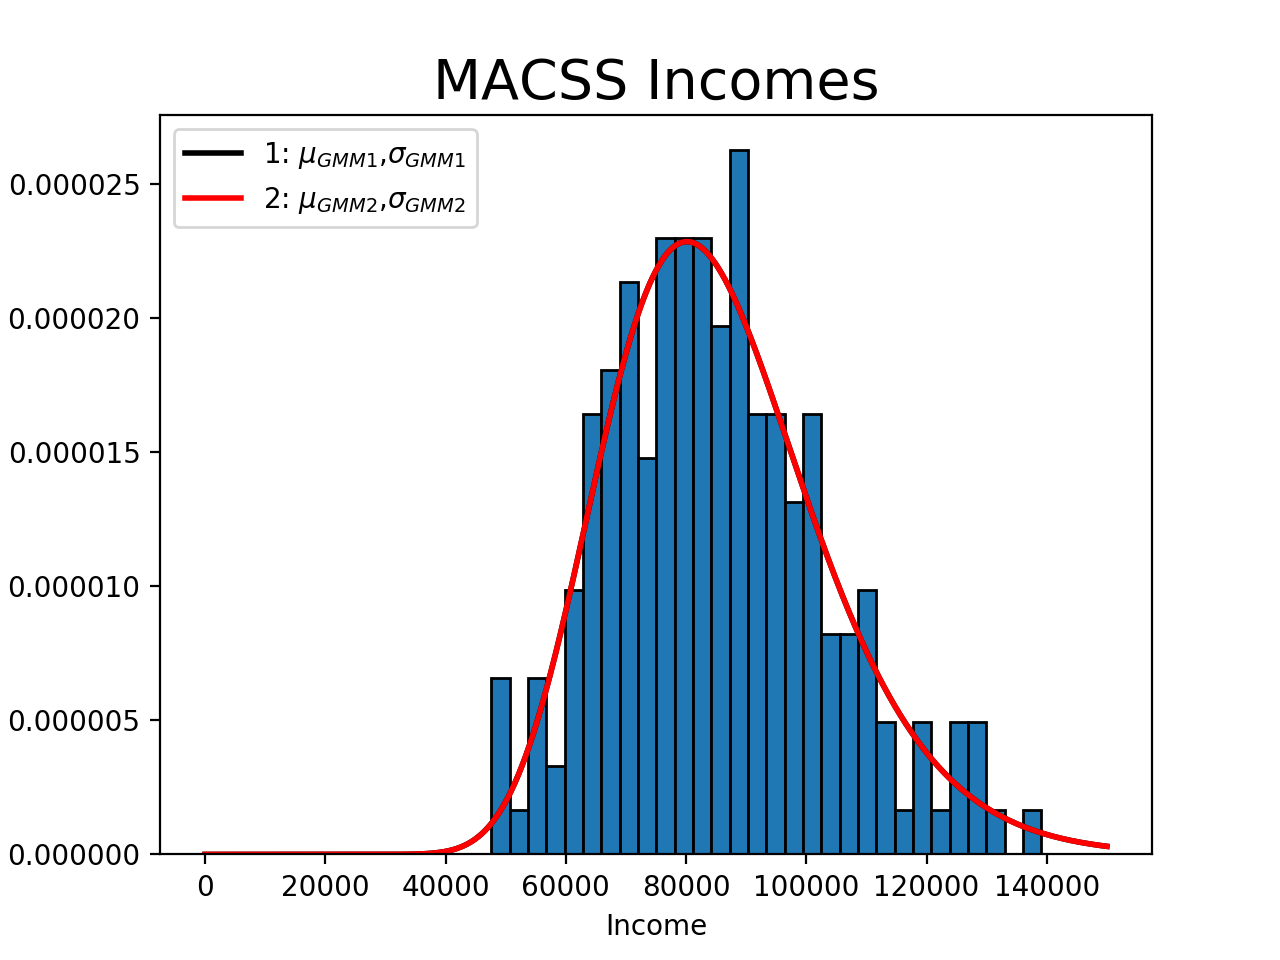

Text(0,0.5,'Percent of Students')

In [1]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
%matplotlib notebook

incomes = np.loadtxt('../../ProblemSets/PS3/incomes.txt')
%matplotlib notebook
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('MACSS Incomes', fontsize=20)
plt.xlabel('Income')
plt.ylabel('Percent of Students')

### (b)

In [2]:
# Define a function to generate the truncated log normal pdf. Adapted from GMM Notebook.
def trunc_log_norm_pdf(xvals, mu, sigma, cutoff=None):
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp(-(np.log(xvals)- mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [3]:
# Compute the data moments for GMM.
def data_moments(xvals):
    mean_data = xvals.mean()
    sd_data = np.sqrt(xvals.var())
    
    return mean_data, sd_data

In [4]:
# Compute the model moments. Adapted from GMM Notebook.
def model_moments(mu, sigma, cutoff):
    xfx = lambda x: x * trunc_log_norm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_log_norm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0, cutoff)
    std_model = var_model**.5
    
    return mean_model, std_model

In [5]:
# Compute the moment error vector (in percent deviation from the data moment vector). Adapted from GMM Notebook.
def err_vec(xvals, mu, sigma, cutoff):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [var_model]])
    err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [6]:
# Compute the criterion for GMM (the weighted sum of squared moment errors). Adapted from GMM Notebook.
def criterion(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff)
    crit_val = err.T @ W @ err
    
    return crit_val

In [7]:
# Perform GMM estimation with weighting matrix W = I using the mu and sigma starting point and the max
# from the MLE estimate.
mu_init = 11.0
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x

In [10]:
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results.x
mean_data, var_data = data_moments(incomes)
print('Value of criterion=', results.fun[0][0])
print('Data moments: Mean Data=', mean_data, ' Standard Deviation Data=', var_data)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1, 150000)
print('Model moments: Mean Model=', mean_model, ' Standard Deviation Model=', var_model)
print('As you can see from the above, the model moments are very close to the data moments.')
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, 150000).reshape(2,)
print('Error vector=', err1)
print('See above for graph.')

mu_GMM1= 11.336910231  sig_GMM1= 0.213027684723
Value of criterion= 5.99512455164e-12
Data moments: Mean Data= 85276.8236063  Standard Deviation Data= 17992.542128
Model moments: Mean Model= 85276.81353707105  Standard Deviation Model= 17992.586131428365
As you can see from the above, the model moments are very close to the data moments.
Error vector= [ -1.18076479e-07   2.44564562e-06]
See above for graph.


In [9]:
# Plot the estimated GMM PDF
dist_pts = np.linspace(0.00001, 150000, 1000)
plt.plot(dist_pts, trunc_log_norm_pdf(dist_pts, mu_GMM1, sig_GMM1, 150000),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

### (c)

In [11]:
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, 150000)
VCV2 = np.dot(err1, err1.T) / incomes.shape[0]
print("VCV 2 Step=", VCV2)
W_hat2 = lin.pinv(VCV2)
print("W_hat 2 Step=", W_hat2)

VCV 2 Step= [[  6.97102743e-17  -1.44386612e-15]
 [ -1.44386612e-15   2.99059125e-14]]
W_hat 2 Step= [[  7.75818913e+10  -1.60690609e+12]
 [ -1.60690609e+12   3.32828593e+13]]


In [12]:
params_init2 = np.array([mu_GMM1, sig_GMM1])
gmm_args2 = (incomes, 150000.0, W_hat2)
results2 = opt.minimize(criterion, params_init2, args=(gmm_args2),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x

In [13]:
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM1)
print('Value of criterion=', results2.fun[0][0])
mean_data, sd_data = data_moments(incomes)
print('Data moments: Mean Data=', mean_data, ' Standard Deviation Data=', sd_data)
mean_model, sd_model = model_moments(mu_GMM2, sig_GMM2, 150000)
print('Model moments: Mean Model=', mean_model, ' Standard Deviation Model=', sd_model)
print('The data moments and model moments are close to each other in this esimation as well; however, \
there is little change from the previous estimate.')
print('See plot above. As you can see, this plot completely covers the previous plot because they are\
so close to each other.')

mu_GMM2= 11.3369069642  sig_GMM2= 0.213027684723
Value of criterion= 0.00089233647737
Data moments: Mean Data= 85276.8236063  Standard Deviation Data= 17992.542128
Model moments: Mean Model= 85276.55718578135  Standard Deviation Model= 17992.539320950746
The data moments and model moments are close to each other in this esimation as well; however, there is little change from the previous estimate.
See plot above. As you can see, this plot completely covers the previous plot because they areso close to each other.


In [14]:
# Plot the estimated GMM PDF for this weighted calc.
dist_pts2 = np.linspace(0.00001, 150000, 1000)
plt.plot(dist_pts2, trunc_log_norm_pdf(dist_pts2, mu_GMM2, sig_GMM2, 150000),
         linewidth=2, color='r', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

### (d)

In [15]:
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [16]:
def lognorm_cdf(x, mu, sigma):
    
    return intgr.quad(lambda x: trunc_log_norm_pdf(x, mu, sigma, 'None'), 1e-10, x)[0]

def model_moments3(mu, sigma):
    
    bpct_1_mod = lognorm_cdf(75000, mu, sigma)
    bpct_2_mod = lognorm_cdf(100000, mu, sigma) - bpct_1_mod
    bpct_3_mod = 1 - bpct_2_mod - bpct_1_mod
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [17]:
def err_vec3(xvals, mu, sigma, cutoff):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod= model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

In [18]:
def criterion3(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [19]:
mu_init = 11.3
sig_init = .2
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
cutoff = 'None'
gmm_args3 = (incomes, cutoff, W_hat)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args3),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM3, sig_GMM3 = results_3.x
print('mu_GMM3=', mu_GMM3, ' sig_GMM3=', sig_GMM3)

mu_GMM3= 11.3356813282  sig_GMM3= 0.210598453605


In [20]:
print('mu_GMM3=', mu_GMM3, ' sig_GMM3=', sig_GMM3)
print('Value of criterion=', results_3.fun[0][0])
first, second, third = data_moments3(incomes)
print('Data moments: Less than 75K=', first, ' 75K to 100K=', second, ' Over 100K=', third)
first_m, second_m, third_m = model_moments3(mu_GMM3, sig_GMM3)
print('Model moments: Less than 75K (model)=', first_m, ' 75K to 100K (model)=', second_m, ' Over 100K \
(model)=', third_m)
print('See plot below.')
print('The data moments are very close in this estimation, like the previous GMM estimation.')
print('This estimation seems to fit the values as well as the previous GMM estimation.')

mu_GMM3= 11.3356813282  sig_GMM3= 0.210598453605
Value of criterion= 2.06249857686e-11
Data moments: Less than 75K= 0.3  75K to 100K= 0.5  Over 100K= 0.2
Model moments: Less than 75K (model)= 0.30000000225873846  75K to 100K (model)= 0.5000000063328626  Over 100K (model)= 0.19999999140839897
See plot below.
The data moments are very close in this estimation, like the previous GMM estimation.
This estimation seems to fit the values as well as the previous GMM estimation.


<IPython.core.display.Javascript object>


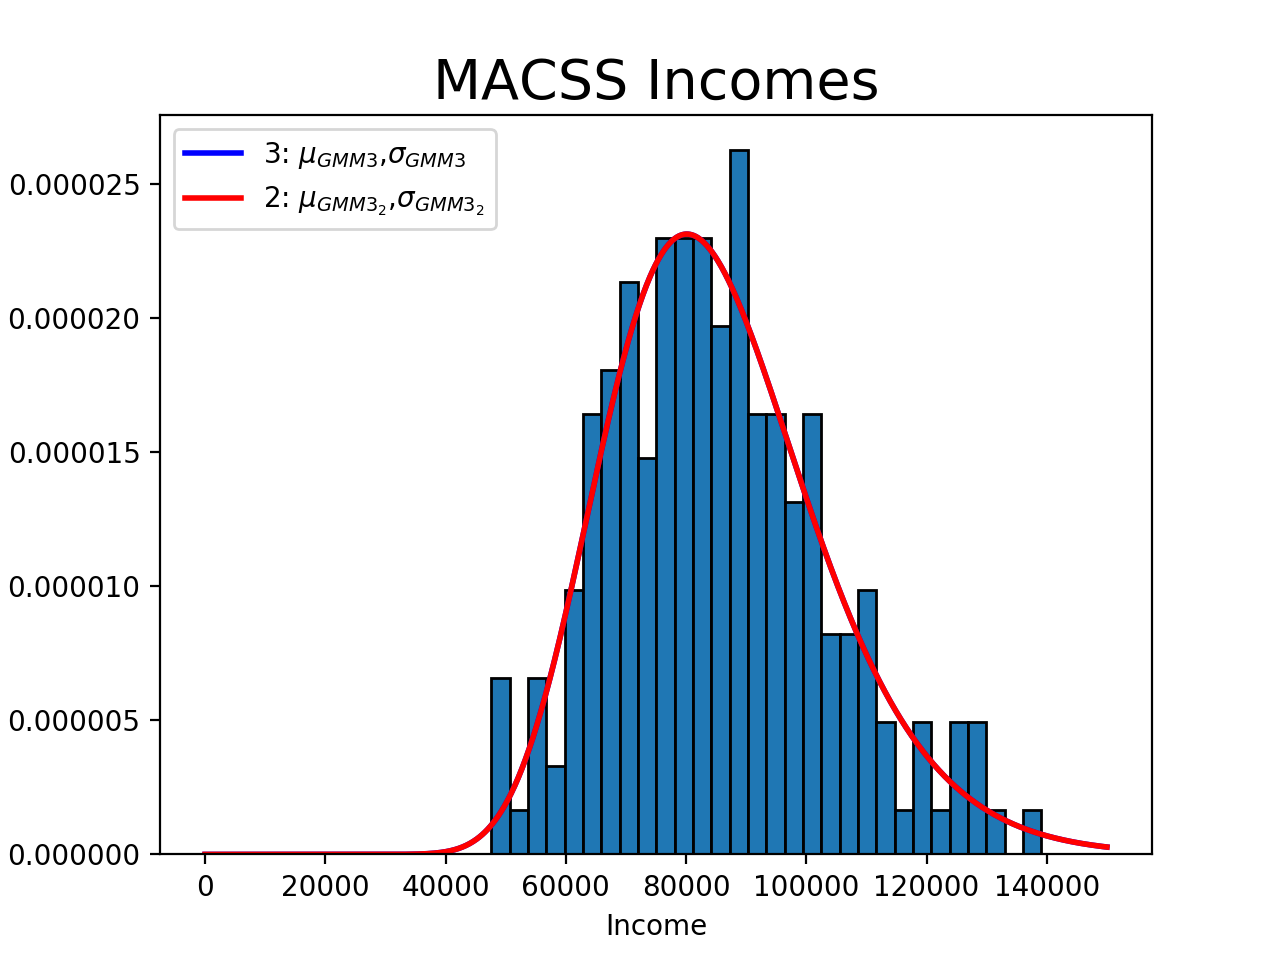

In [21]:
# Plot the estimated GMM PDF for this weighted calc.
%matplotlib notebook
fig_2 = plt.figure()
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('MACSS Incomes', fontsize=20)
plt.xlabel('Income')
plt.ylabel('Percent of Students')
dist_pts3 = np.linspace(0.00001, 150000, 1000)
plt.plot(dist_pts3, trunc_log_norm_pdf(dist_pts3, mu_GMM3, sig_GMM3, 'None'),
         linewidth=2, color='b', label='3: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')

### (e)

In [22]:
err1_3 = err_vec3(incomes, mu_GMM3, sig_GMM3, 'None')
VCV2_3 = np.dot(err1_3, err1_3.T) / incomes.shape[0]
print("VCV 2 Step 3 Moments=", VCV2_3)
W_hat2_3 = lin.pinv(VCV2_3)
print("W_hat 2 Step 3 Moments=", W_hat2_3)

VCV 2 Step 3 Moments= [[  2.83438861e-15   4.76809344e-15  -1.61718165e-14]
 [  4.76809344e-15   8.02102966e-15  -2.72047143e-14]
 [ -1.61718165e-14  -2.72047143e-14   9.22695106e-14]]
W_hat 2 Step 3 Moments= [[  2.66521390e+11   4.48350269e+11  -1.52065776e+12]
 [  4.48350269e+11   7.54228256e+11  -2.55809604e+12]
 [ -1.52065776e+12  -2.55809604e+12   8.67622674e+12]]


In [23]:
params_init3 = np.array([mu_GMM3, sig_GMM3])
cutoff = 'None'
gmm_args3_2 = (incomes, cutoff, W_hat2_3)
results3_2 = opt.minimize(criterion3, params_init3, args=(gmm_args3_2),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM3_2, sig_GMM3_2 = results3_2.x

In [24]:
print('mu_GMM3_2=', mu_GMM3_2, ' sig_GMM3_2=', sig_GMM3_2)
print('Value of criterion=', results3_2.fun[0][0])
first, second, third = data_moments3(incomes)
print('Data moments: Less than 75K=', first, ' 75K to 100K=', second, ' Over 100K=', third)
first_m, second_m, third_m = model_moments3(mu_GMM3_2, sig_GMM3_2)
print('Model moments: Less than 75K (model)=', first_m, ' 75K to 100K (model)=', second_m, ' Over 100K \
(model)=', third_m)
print('The data moments are slightly closer than the previous GMM estimation with three moments.')
print('THowever, the difference is close to 10*-11, so there is not much improvement, as you can see from the \
graph below that plots over the previous graph.')

mu_GMM3_2= 11.3356813291  sig_GMM3_2= 0.210598455213
Value of criterion= 84.9605055675
Data moments: Less than 75K= 0.3  75K to 100K= 0.5  Over 100K= 0.2
Model moments: Less than 75K (model)= 0.30000000217232564  75K to 100K (model)= 0.5000000034280949  Over 100K (model)= 0.19999999439957944
The data moments are slightly closer than the previous GMM estimation with three moments.
THowever, the difference is close to 10*-11, so there is not much improvement, as you can see from the graph below that plots over the previous graph.


In [25]:
# Plot the estimated GMM PDF for this weighted calc.
dist_pts3 = np.linspace(0.00001, 150000, 1000)
plt.plot(dist_pts3, trunc_log_norm_pdf(dist_pts3, mu_GMM3_2, sig_GMM3_2, 150000),
         linewidth=2, color='r', label='2: $\mu_{GMM3_2}$,$\sigma_{GMM3_2}$')
plt.legend(loc='upper left')

### (f)

It depends on the question. If we are hoping to match the mu/sigma, the first two models are better. If we are interested in matching the three percentage moments, the last two are better. In both cases I believe the first estimate with the I weighting matrix is sufficient, because the weighting matrix did not appear to improve our estimate greatly.

## Question 2
### (a)

In [26]:
sick_data = np.loadtxt("sick.txt", delimiter=',', skiprows=1)
age = sick_data[:,1]
children = sick_data[:,2]
temp_winter = sick_data[:,3]
sick = sick_data[:,0]
n = len(sick)

In [27]:
def err_sick(xvals, b0, b1, b2, b3):
    model = b0 + b1*age + b2*children + b3*temp_winter
    err = sick - model 
    
    return err**2

In [28]:
def criterion_sick(params, *args):
    
    b0, b1, b2, b3 = params
    xvals, W = args
    err = err_sick(xvals, *params)
    crit_val = err.T @ W @ err
    
    return crit_val

In [29]:
params_init_sick = np.array([0, 0, 0, 0])
W_sick = np.eye(n)
gmm_args_sick = (sick_data, W_sick)
results_sick = opt.minimize(criterion_sick, params_init_sick, args=(gmm_args_sick),
                       method='L-BFGS-B')

In [30]:
b0, b1, b2, b3 = results_sick.x
criterion_sick = criterion_sick(results_sick.x, *gmm_args_sick)

In [31]:
print("B0 = ", b0, ", B1 =", b1, ", B2 =", b2, ", B3=", b3)
print("Value of criterion function = ", criterion_sick)

B0 =  0.249719894051 , B1 = 0.0131150472575 , B2 = 0.399483216748 , B3= -0.0100796852574
Value of criterion function =  4.3660540377e-08
